In [2]:
import numpy as np
from skimage import measure
import sys

import trimesh
import open3d as o3d
from scipy.special import sph_harm
import ipywidgets as widgets
from IPython.display import display, clear_output

def R_nl(n, l, r, a0=1.0):
    x = r / a0
    if (n, l) == (4, 2):
        return (x**2) * np.exp(-x/3.0)
    return np.exp(-x/n)

def Y_real(l, m, theta, phi):
    Y = sph_harm(m, l, phi, theta)
    if m > 0:
        return np.sqrt(2) * np.real(Y)
    elif m < 0:
        return np.sqrt(2) * np.imag(Y)
    else:
        return np.real(Y)

def genera_mesh(asym=0.3, iso_fraction=0.1, stretch_z=1.6, stretch_xy=0.6):
    n, l, m = 4, 2, 0
    a0 = 1.00
    grid_N = 200
    Rmax = 25.0

    xs = np.linspace(-Rmax, Rmax, grid_N)
    ys = np.linspace(-Rmax, Rmax, grid_N)
    zs = np.linspace(-Rmax, Rmax, grid_N)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")

    r = np.sqrt(X**2 + Y**2 + Z**2) + 1e-12
    theta = np.arccos(np.clip(Z / r, -1.0, 1.0))
    phi = (np.arctan2(Y, X) + 2*np.pi) % (2*np.pi)

    Rpart = R_nl(n, l, r, a0)
    Ypart = Y_real(l, m, theta, phi)
    direction_factor = 1 + (1 - asym) * np.cos(theta)
    psi = Rpart * Ypart * direction_factor

    rho = psi**2
    rho -= rho.min()
    rho /= rho.max()

    Xs = X * stretch_xy
    Ys = Y * stretch_xy
    Zs = Z * stretch_z

    spacing = (
        (xs[1]-xs[0])*stretch_xy,
        (ys[1]-ys[0])*stretch_xy,
        (zs[1]-zs[0])*stretch_z
    )

    verts, faces, _, _ = measure.marching_cubes(rho, level=iso_fraction, spacing=spacing)
    mesh = trimesh.Trimesh(vertices=verts, faces=faces, process=True)

    # Visualizza mesh in Open3D
    o3mesh = o3d.geometry.TriangleMesh(
        o3d.utility.Vector3dVector(mesh.vertices),
        o3d.utility.Vector3iVector(mesh.faces)
    )
    o3mesh.compute_vertex_normals()
    o3d.visualization.draw_geometries([o3mesh])

# --- Slider interattivi ---
asym_slider = widgets.FloatSlider(value=0.3, min=0.0, max=1.0, step=0.05, description='Asymmetry')
iso_slider = widgets.FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01, description='Iso fraction')
stretch_z_slider = widgets.FloatSlider(value=1.6, min=0.5, max=2.5, step=0.1, description='Stretch Z')
stretch_xy_slider = widgets.FloatSlider(value=0.6, min=0.3, max=1.5, step=0.1, description='Stretch XY')

ui = widgets.VBox([asym_slider, iso_slider, stretch_z_slider, stretch_xy_slider])

out = widgets.interactive_output(genera_mesh, {
    'asym': asym_slider,
    'iso_fraction': iso_slider,
    'stretch_z': stretch_z_slider,
    'stretch_xy': stretch_xy_slider
})

display(ui, out)

Output()

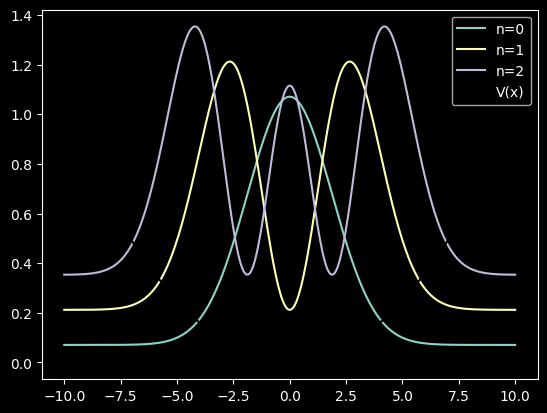

Primi livelli energetici: [0.07070947 0.21213373 0.35364765 0.49576409 0.64034012]


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# griglia spaziale
N = 400
x_min, x_max = -10, 10
x = np.linspace(x_min, x_max, N)
dx = x[1] - x[0]

# potenziale: buca armonica o coulombiana o quello che vuoi
V = 0.01 * x**2       # armonico
# V = -1 / np.sqrt(x**2 + 0.1)  # coulombiano regolarizzato

# costante ridotta
hbar = 1
m = 1

# matrice del laplaciano (a 3 diagonali)
diag = np.ones(N) * (-2)
off  = np.ones(N - 1)
laplacian = (np.diag(diag) + np.diag(off, 1) + np.diag(off, -1)) / dx**2

# Hamiltoniano discreto
H = -(hbar**2 / (2*m)) * laplacian + np.diag(V)

# autovalori e autovettori
E, psi = np.linalg.eigh(H)

# normalizza e mostra le prime funzioni d’onda
for n in range(3):
    plt.plot(x, psi[:, n]**2 / np.max(psi[:, n]**2) + E[n], label=f'n={n}')
plt.plot(x, V, 'k--', label='V(x)')
plt.legend(); plt.show()

print("Primi livelli energetici:", E[:5])